In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Data Preparation & Exploration

In [2]:
df=pd.read_csv('diabetic_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [4]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


First ,we will remove ID columns because this will not contribute to our model

In [5]:
#removing id columns
df.drop(['encounter_id','patient_nbr'],axis=1,inplace=True)

In [6]:
list_unique_columns=[]
for i in df.columns:
    if len(df[i].value_counts())==1:
        list_unique_columns.append(i)
for i in list_unique_columns:
    df.drop([i],axis=1,inplace=True) 

In our dataset, we have '?' as a value for many records so replace it with nan

In [7]:
#replace ? with nan
df=df.replace('?',np.nan) 

In [8]:
#missing value function
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return tt    

missing_data(df)['Percent'].sort_values(ascending=False)

weight                      96.858479
medical_specialty           49.082208
payer_code                  39.557416
race                         2.233555
diag_3                       1.398306
diag_2                       0.351787
diag_1                       0.020636
num_medications              0.000000
max_glu_serum                0.000000
number_diagnoses             0.000000
number_inpatient             0.000000
number_emergency             0.000000
number_outpatient            0.000000
num_lab_procedures           0.000000
num_procedures               0.000000
diabetesMed                  0.000000
time_in_hospital             0.000000
admission_source_id          0.000000
discharge_disposition_id     0.000000
admission_type_id            0.000000
age                          0.000000
gender                       0.000000
A1Cresult                    0.000000
readmitted                   0.000000
repaglinide                  0.000000
nateglinide                  0.000000
change      

In [9]:
#weight column since it has more missing value 
df['weight'].value_counts()

[75-100)     1336
[50-75)       897
[100-125)     625
[125-150)     145
[25-50)        97
[0-25)         48
[150-175)      35
[175-200)      11
>200            3
Name: weight, dtype: int64

Since weight is not filled often we are creating new flag column and dropping original column

In [10]:
df['has_weight']=df['weight'].notnull().astype('int')
df.drop(['weight'],axis=1,inplace=True)

Analyzing medical_speciality column

In [11]:
df['medical_specialty'].isnull().sum()
df['medical_specialty']=df['medical_specialty'].fillna('UNK') #filling null with unk
print(df['medical_specialty'].nunique()) #more categories

73


In [12]:
print(df['medical_specialty'].value_counts())

UNK                                 49949
InternalMedicine                    14635
Emergency/Trauma                     7565
Family/GeneralPractice               7440
Cardiology                           5352
                                    ...  
Dermatology                             1
Psychiatry-Addictive                    1
Perinatology                            1
Surgery-PlasticwithinHeadandNeck        1
Pediatrics-InfectiousDiseases           1
Name: medical_specialty, Length: 73, dtype: int64


Since many categories has less sample we will change the column into the top 10 specialities 
and then an other category

In [13]:
top_10=['UNK','InternalMedicine',
        'Emergency/Trauma','Family/GeneralPractice','Cardiology','Surgery-General',
        'Nephrology','Orthopedics','Orthopedics-Reconstructive','Radiologist']

df.loc[~df['medical_specialty'].isin(top_10),'medical_specialty']='Other'

Analyzing payer_code column

In [14]:
print(df['payer_code'].isnull().sum())

print(df['payer_code'].value_counts())

df['payer_code']=df['payer_code'].fillna('UNK') #filling null with unk

40256
MC    32439
HM     6274
SP     5007
BC     4655
MD     3532
CP     2533
UN     2448
CM     1937
OG     1033
PO      592
DM      549
CH      146
WC      135
OT       95
MP       79
SI       55
FR        1
Name: payer_code, dtype: int64


Analyzing race column

In [15]:
df['race'].isnull().sum()
df['race'].value_counts()

df['race']=df['race'].fillna('UNK') #filling null with unk

In [16]:
#Generating output variable
#we need to check whether a patient admitted within 30 days or not
df['target']=(df['readmitted']=='<30').astype('int')

#dropping readmitted column
df.drop(['readmitted'],axis=1,inplace=True)

In [17]:
print(df['age'].value_counts())

cleanup_age = {"age":     {"[0-10)": 0, "[10-20)": 10,"[20-30)": 20,"[30-40)": 30,"[40-50)": 40,"[50-60)": 50,
    "[60-70)": 60,"[70-80)": 70,"[80-90)": 80,"[90-100)": 90}}

df.replace(cleanup_age, inplace=True)

[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64


In [18]:
#analyzing gender column
df['gender'].value_counts()
#removing invalid/unknown entries for gender
df=df[df['gender']!='Unknown/Invalid']

Text(0.5, 1.0, 'Distrinution of Readmission')

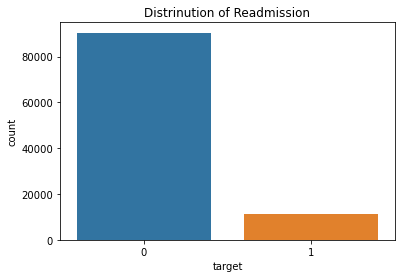

In [19]:
#Distribution of Readmission
sns.countplot(df['target']).set_title('Distrinution of Readmission')

Insight from above graph: Our target variable is imbalance.
Number of readmitted patient are quite less as compared to Not readmitted

In [20]:
#checking for balance data
print(sum(df['target'].values)/len(df['target'].values)) 

0.11160244882717688


Only 11% is re hospitalized so this is imbalance dataset

Text(0.5, 1.0, 'Time in Hospital VS. Readmission')

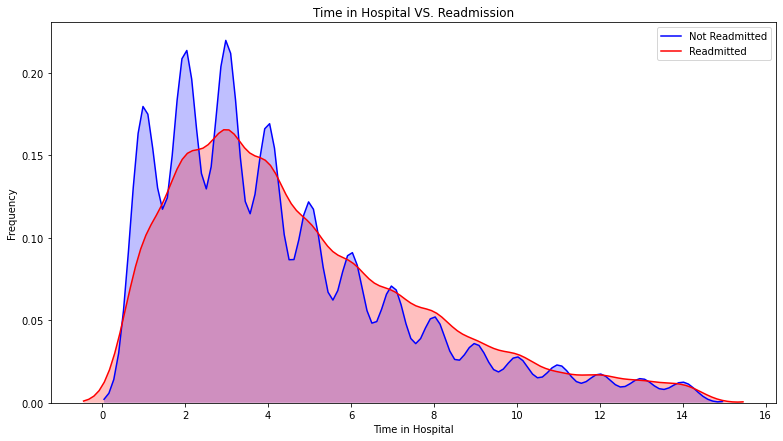

In [21]:
#time in hospital vs readmitted
fig = plt.figure(figsize=(13,7),)
ax=sns.kdeplot(df.loc[(df['target'] == 0),'time_in_hospital'] , color='b',shade=True,label='Not Readmitted')
ax=sns.kdeplot(df.loc[(df['target'] == 1),'time_in_hospital'] , color='r',shade=True, label='Readmitted')
ax.set(xlabel='Time in Hospital', ylabel='Frequency')
plt.title('Time in Hospital VS. Readmission')

Insight from above graph: If no of days in hospital increased readmission rate is getting decreased.
Mostly patient between 3 to 4 days are admitted frequently

Text(0.5, 1.0, 'Age of Patient VS. Readmission')

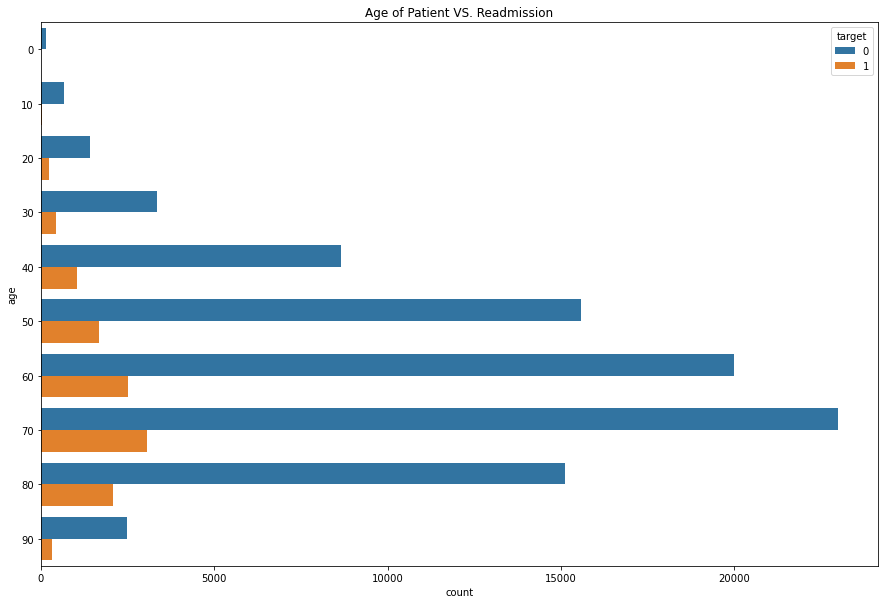

In [22]:
#age vs readmission

fig = plt.figure(figsize=(15,10))
sns.countplot(y= df['age'], hue = df['target']).set_title('Age of Patient VS. Readmission')

Insight from above graph: Patient with age 60 and 70 have more readmission

Text(0.5, 1.0, 'Gender of Patient VS. Readmission')

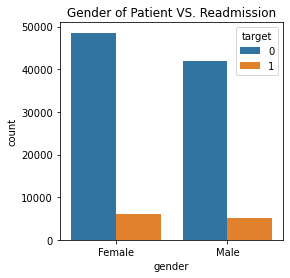

In [23]:
#Gender and Readmission
#Male = 1
#Female = 0

fig = plt.figure(figsize=(4,4))
sns.countplot(df['gender'], hue = df['target']).set_title("Gender of Patient VS. Readmission")

Insight from above graph: Patient female have more readmission

Text(0.5, 1.0, 'Diabetes Medication prescribed VS Readmission')

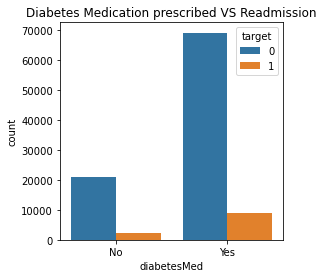

In [24]:
#diabetic medication vs readmission

fig = plt.figure(figsize=(4,4))
sns.countplot(df['diabetesMed'], hue = df['target']).set_title('Diabetes Medication prescribed VS Readmission')

Insight from above graph : Patients provided with diabetes medication readmitted often

Glucose Serum test - A blood glucose test is used to find out if your blood sugar levels are in the healthy range.
It is often used to help diagnose and monitor diabetes.

'>200' : = indicates diabetes '>300' : = Indicates diabetes 'Norm' : = Normal 'None' : = test was not taken

Text(0.5, 1.0, 'Glucose test serum test result VS. Readmission')

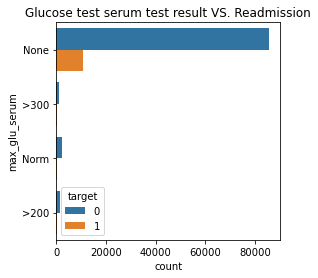

In [25]:
#max_glue_serum vs target
fig = plt.figure(figsize=(4,4))
sns.countplot(y = df['max_glu_serum'], hue = df['target']).set_title('Glucose test serum test result VS. Readmission')

Insight from above graph : Patient who doen't take max glue serum test is readmitted often

A1C result and Readmission A1C test - The A1C test is a blood test that provides information about your average levels of blood glucose, 
also called blood sugar, over the past 3 months

'>7' :1
'>8' :1
Norm : 0 = Normal
None : -99 = Test was not taken

Text(0.5, 1.0, 'A1C test result VS. Readmission')

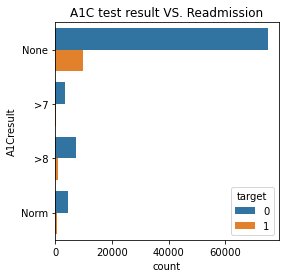

In [26]:
#a1c test result vs target
fig = plt.figure(figsize=(4,4))
sns.countplot(y= df['A1Cresult'], hue = df['target']).set_title('A1C test result VS. Readmission')

Insight from above graph : Patient who doen't take a1ctest is readmitted often

Text(0.5, 1.0, 'admission_type_id VS. Readmission')

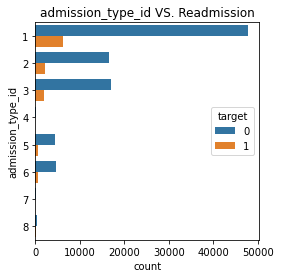

In [27]:
#admission type vs readmission
#1-	Emergency
#2-Urgent
#3-Elective
#4-Newborn
#5-Not Available
#6-NULL
#7-Trauma Center
#8-Not Mapped

fig = plt.figure(figsize=(4,4))
sns.countplot(y= df['admission_type_id'], hue = df['target']).set_title('admission_type_id VS. Readmission')

Insight from above graph : Patient who admitted as emergency has more readmission

Text(0.5, 1.0, 'discharge_disposition_id VS. Readmission')

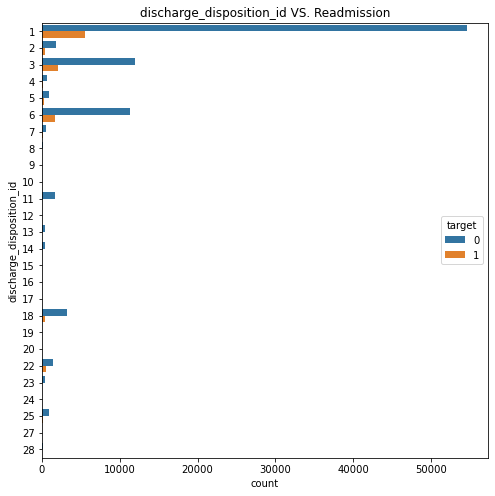

In [28]:
#discharge_disposition_id VS. Readmission
fig = plt.figure(figsize=(8,8))
sns.countplot(y= df['discharge_disposition_id'], hue = df['target']).set_title('discharge_disposition_id VS. Readmission')

Insight from above graph : Patient who discharged to home has more readmission rate

In [29]:
categorical_feature=df.select_dtypes(include='object')
cat=categorical_feature.columns
print(cat)

Index(['race', 'gender', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2',
       'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed'],
      dtype='object')


Removing diag_ columns bcoz it is categorical and have more levels ,
this is handled by grouping which is done in later part

In [30]:
cat=['race', 'gender', 'payer_code', 'medical_specialty', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed']

In [31]:
#taking copy of dataframe
df_copy=df.copy()

Numeric and categorical columns: 'admission_type_id','discharge_disposition_id','admission_source_id'

In [32]:
cols_cat_num=['admission_type_id','discharge_disposition_id','admission_source_id']
df[cols_cat_num]=df[cols_cat_num].astype('str')
df_cat=pd.get_dummies(df[cat+cols_cat_num],drop_first=True)

In [33]:
print(df_cat.columns)

Index(['race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other',
       'race_UNK', 'gender_Male', 'payer_code_CH', 'payer_code_CM',
       'payer_code_CP', 'payer_code_DM',
       ...
       'admission_source_id_20', 'admission_source_id_22',
       'admission_source_id_25', 'admission_source_id_3',
       'admission_source_id_4', 'admission_source_id_5',
       'admission_source_id_6', 'admission_source_id_7',
       'admission_source_id_8', 'admission_source_id_9'],
      dtype='object', length=137)


In [34]:
#dropping encoded columns
for i in cat:
    df_copy.drop([i],axis=1,inplace=True)

In [35]:
#concating encoded columns and other columns
df_copy=pd.concat([df_copy,df_cat],axis=1)

Checking diag columns

In [36]:
df_copy['diag_3'].isnull().sum()
df_copy.dropna(inplace=True)
print(df_copy['diag_1'].nunique())
print(df_copy['diag_2'].nunique())
print(df_copy['diag_3'].nunique())

715
743
789


In [37]:
diag_cols = ['diag_1','diag_2','diag_3']
for col in diag_cols:
    df_copy[col] = df_copy[col].str.replace('E','-')
    df_copy[col] = df_copy[col].str.replace('V','-')
    condition = df_copy[col].str.contains('250')
    df_copy.loc[condition,col] = '250'

df_copy[diag_cols] = df_copy[diag_cols].astype(float)

In [38]:
# diagnosis grouping
for col in diag_cols:
    df_copy['temp']=np.nan
    
    condition = df_copy[col]==250
    #condition = df_copy['diag_1']==250
    df_copy.loc[condition,'temp']='Diabetes'
    
    condition = (df_copy[col]>=390) & (df_copy[col]<=458) | (df_copy[col]==785)
    df_copy.loc[condition,'temp']='Circulatory'
    
    condition = (df_copy[col]>=460) & (df_copy[col]<=519) | (df_copy[col]==786)
    df_copy.loc[condition,'temp']='Respiratory'
    
    condition = (df_copy[col]>=520) & (df_copy[col]<=579) | (df_copy[col]==787)
    df_copy.loc[condition,'temp']='Digestive'
    condition = (df_copy[col]>=580) & (df_copy[col]<=629) | (df_copy[col]==788)
    df_copy.loc[condition,'temp']='Genitourinary'
    
    condition = (df_copy[col]>=800) & (df_copy[col]<=999)
    df_copy.loc[condition,'temp']='Injury'
    
    condition = (df_copy[col]>=710) & (df_copy[col]<=739)
    df_copy.loc[condition,'temp']='Muscoloskeletal'
    
    condition = (df_copy[col]>=140) & (df_copy[col]<=239)
    df_copy.loc[condition,'temp']='Neoplasms'
    condition = df_copy[col]==0
    df_copy.loc[condition,col]='?'
    df_copy['temp']=df_copy['temp'].fillna('Others')
    condition = df_copy['temp']=='0'
    df_copy.loc[condition,'temp']=np.nan
    df_copy[col]=df_copy['temp']
    df_copy.drop('temp',axis=1,inplace=True)

In [39]:
#ENCODING DIAG_ COLUMNS
df_cat_diag=pd.get_dummies(df_copy[diag_cols],drop_first=True)

#dropping encoded columns
for i in diag_cols:
    df_copy.drop([i],axis=1,inplace=True)

df_copy=pd.concat([df_copy,df_cat_diag],axis=1)

In [40]:
X=df_copy.drop(['target'],axis=1)
y=df_copy['target']

# Building Training/Validation/Test Samples

In [41]:
# shuffle the samples
df_copy = df_copy.sample(n = len(df_copy), random_state = 42)
df_copy = df_copy.reset_index(drop = True)

In [42]:
# Save 30% of the data as validation and test data 
df_valid_test=df_copy.sample(frac=0.30,random_state=42)
print('Split size: %.3f'%(len(df_valid_test)/len(df_copy)))

Split size: 0.300


In [43]:
df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)


In [44]:
# use the rest of the data as training data
df_train_all=df_copy.drop(df_valid_test.index)

In [45]:
df_train_all.to_csv('df_train_all.csv',index=False)
#df_train.to_csv('df_train.csv',index=False)
df_valid.to_csv('df_valid.csv',index=False)
df_test.to_csv('df_test.csv',index=False)

# Logistic Regression

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
logit = LogisticRegression(fit_intercept=True, penalty='l2')
logit.fit(X_train, y_train)
logit_pred = logit.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(logit_pred, name = 'Predict'), margins = True)
print("Accuracy is {0:.3f}".format(accuracy_score(y_test, logit_pred)))
print("Precision is {0:.3f}".format(precision_score(y_test, logit_pred)))
print("Recall is {0:.3f}".format(recall_score(y_test, logit_pred)))

accuracy_logit = accuracy_score(y_test, logit_pred)
precision_logit = precision_score(y_test, logit_pred)
recall_logit = recall_score(y_test, logit_pred)

Accuracy is 0.886
Precision is 0.462
Recall is 0.013


# Decision Tree

In [47]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(max_depth=28, criterion = "entropy", min_samples_split=10)
dtree.fit(X_train, y_train)
dtree_pred = dtree.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(dtree_pred, name = 'Predict'), margins = True)

print("Accuracy is {0:.3f}".format(accuracy_score(y_test, dtree_pred)))
print("Precision is {0:.3f}".format(precision_score(y_test, dtree_pred)))
print("Recall is {0:.3f}".format(recall_score(y_test, dtree_pred)))


accuracy_dtree = accuracy_score(y_test, dtree_pred)
precision_dtree = precision_score(y_test, dtree_pred)
recall_dtree = recall_score(y_test, dtree_pred)

Accuracy is 0.839
Precision is 0.191
Recall is 0.129


Feature Importance for Decision Tree

                     Feature  Importance
9           number_emergency    0.014709
2   discharge_disposition_id    0.023081
8          number_outpatient    0.023606
11          number_diagnoses    0.031042
6             num_procedures    0.036753
0                        age    0.038627
4           time_in_hospital    0.050348
10          number_inpatient    0.052460
7            num_medications    0.100494
5         num_lab_procedures    0.114628


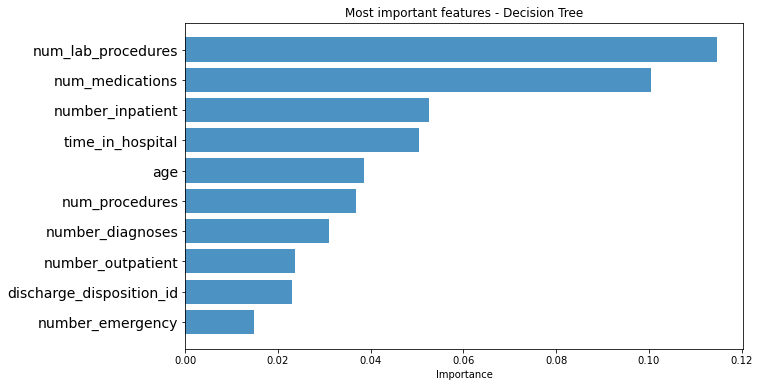

In [48]:
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = dtree.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
print(most_imp_features)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Decision Tree')
plt.show()

# Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier
rm = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "gini", min_samples_split=10)
rm.fit(X_train, y_train)

rm_prd = rm.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(rm_prd, name = 'Predict'), margins = True)

print("Accuracy is {0:.3f}".format(accuracy_score(y_test, rm_prd)))
print("Precision is {0:.3f}".format(precision_score(y_test, rm_prd)))
print("Recall is {0:.3f}".format(recall_score(y_test, rm_prd)))

accuracy_rm = accuracy_score(y_test, rm_prd)
precision_rm = precision_score(y_test, rm_prd)
recall_rm = recall_score(y_test, rm_prd)

Accuracy is 0.887
Precision is 0.531
Recall is 0.010


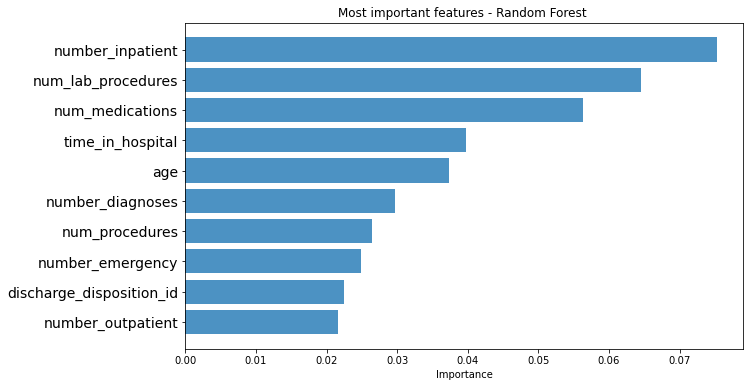

In [50]:
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = rm.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest ')
plt.show()

([<matplotlib.axis.XTick at 0x1b7043a71c0>,
 [Text(0, 0, 'Logistic Regression'),
  Text(0, 0, 'Decision Tree'),
  Text(0, 0, 'Random Forests')])

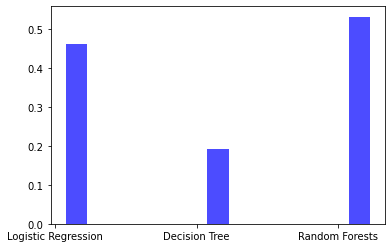

In [51]:
ax = plt.subplot(111)

models = ['Logistic Regression', 'Decision Tree', 'Random Forests']
values = [precision_logit, precision_dtree, precision_rm]
model = np.arange(len(models))

plt.bar(model+0.15, values, align='center', width = 0.15, alpha=0.7, color = 'blue', label = 'precision')
plt.xticks(model, models)

In [52]:
#Recall

Text(0.5, 1.0, 'Model')

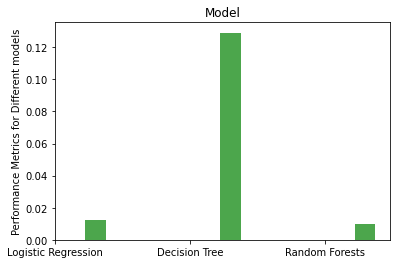

In [53]:
ax = plt.subplot(111)

models = ['Logistic Regression', 'Decision Tree', 'Random Forests' ]
values = [recall_logit, recall_dtree, recall_rm, ]
model = np.arange(len(models))

plt.bar(model+0.3, values, align='center', width = 0.15, alpha=0.7, color = 'green', label = 'recall')
plt.xticks(model, models)
plt.title('Recall')

plt.ylabel('Performance Metrics for Different models')
plt.title('Model')


In [54]:
# Precision


([<matplotlib.axis.XTick at 0x1b7070885b0>,
 [Text(0, 0, 'Logistic Regression'),
  Text(0, 0, 'Decision Tree'),
  Text(0, 0, 'Random Forests')])

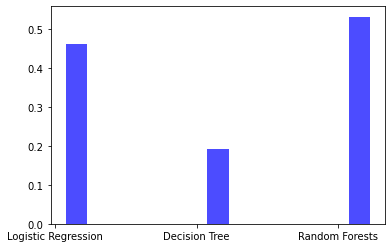

In [55]:
ax = plt.subplot(111)

models = ['Logistic Regression', 'Decision Tree', 'Random Forests']
values = [precision_logit, precision_dtree, precision_rm]
model = np.arange(len(models))

plt.bar(model+0.15, values, align='center', width = 0.15, alpha=0.7, color = 'blue', label = 'precision')
plt.xticks(model, models)

([<matplotlib.axis.XTick at 0x1b7070d9b80>,
 [Text(0, 0, 'Logistic Regression'),
  Text(0, 0, 'Decision Tree'),
  Text(0, 0, 'Random Forests')])

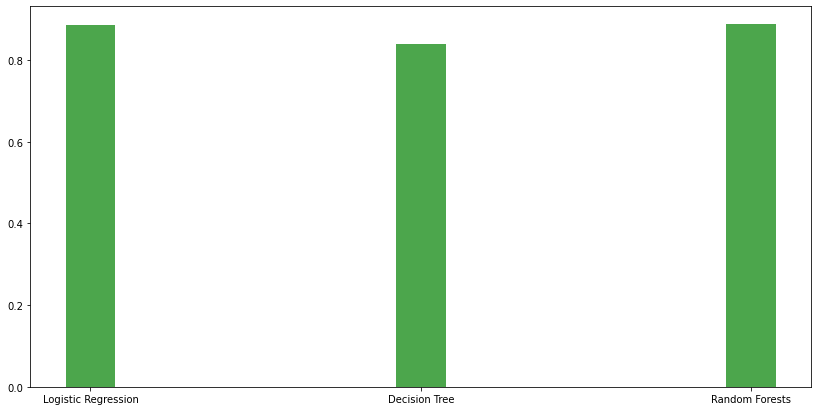

In [56]:
plt.figure(figsize=(14, 7))
ax = plt.subplot(111)

models = ['Logistic Regression', 'Decision Tree', 'Random Forests']
values = [accuracy_logit, accuracy_dtree, accuracy_rm]
model = np.arange(len(models))

plt.bar(model, values, align='center', width = 0.15, alpha=0.7, color = 'Green', label= 'accuracy')
plt.xticks(model, models)

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimators=[('dtree', dtree), ('rm', rm), ('logit', logit)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='hard')


In [59]:
#fit model to training data
ensemble.fit(X_train, y_train)
#test our model on the test data
ensemble.score(X_test, y_test)

0.8869750274332457